In [11]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import math
import csv
import json

def to_seconds(time):
    return round(time, 0)

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

def clean_file_name(f):
    return f.replace(f'{os.getcwd()}/ready/', '').replace('.csv.pkl', '').replace('.', '')

In [12]:
mypath = os.getcwd() + '/ready'
files = [''.join([mypath, '/', f]) for f in listdir(mypath) if isfile(join(mypath, f)) ]

### Evaluating Sparsity

Readings are at roughly the second level. We will plot and extract data at that temporal resolution, this can always be altered if we get denser reading intervals

In [13]:
scam = np.load('/Users/lauren/marinetti/ready/SCam3_tt.csv.pkl', allow_pickle=True)
scam = np.squeeze(scam)

scam_s  = list(map(to_seconds, scam))

scam_s = list(map(lambda x: x - to_seconds(min(scam)), scam_s))

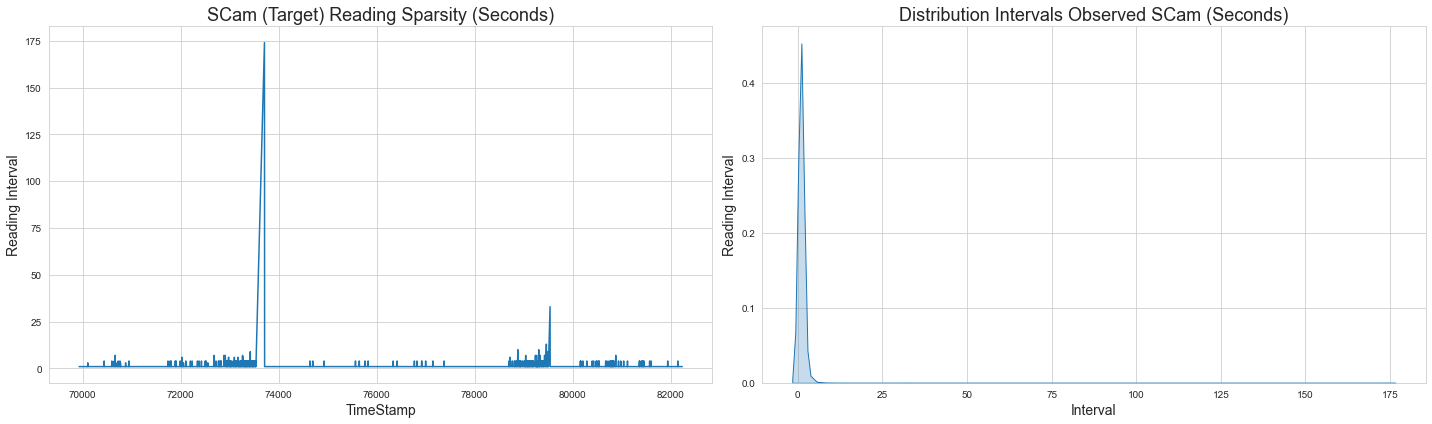

In [14]:
#load SCam Data
scam_diffs = np.diff(scam_s)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

ax1.plot(scam[1:], scam_diffs) 
ax1.set_title(label = "SCam (Target) Reading Sparsity (Seconds)", fontdict = { 'fontsize': 18})
ax1.set_ylabel("Reading Interval", fontdict = { 'fontsize': 14})
ax1.set_xlabel("TimeStamp", fontdict = { 'fontsize': 14})


sns.set_style('whitegrid')
p = sns.kdeplot(np.array(scam_diffs), bw_method=0.5, fill=True, ax=ax2)
p.set_title(label='Distribution Intervals Observed SCam (Seconds)', fontdict = { 'fontsize': 18})
p.set_ylabel("Reading Interval", fontdict = { 'fontsize': 14})
p.set_xlabel("Interval", fontdict = { 'fontsize': 14})

plt.tight_layout()

### ETL: ML-Ready Data
Create a dataframe for analysis and raw data for downstream ML models 

In [15]:
names = []
              
FLAT_NAMES = ['xCentroid', 'xrms', 'yCentroid', 'yrms', 'uCentroid', 'urms', 'vCentroid', 'vrms', 'Gaussian_Sum']

observations = []
files = [file for file in files if 'tt' not in file.replace('marinetti', '').lower()]
for file_name in files: 
    x = np.load(file_name, allow_pickle=True)
    if 'COM' in file_name:
        #this is a bit dodgy 
        x = np.array(list(map(np.float32, x[1:])))
        x = np.expand_dims(x, axis=1)
    if x.shape[0]: #some are 0
        if x.shape[1] > 1:
            flatten = np.split(x, x.shape[1], axis =1)
            for j, f in enumerate(flatten):
                expand_name = clean_file_name(file_name) + '_'+ FLAT_NAMES[j]
                names.append(expand_name)
                observations.append(f)
        else:
            names.append(clean_file_name(file_name))
            observations.append(x)
            
observations = np.concatenate(observations, axis = 1)

N_COLUMNS = 50

### Make DataFrame

Make the correct datetime intervals by doing a join on a dataframe with dense readings and the one constructed from the actual readings 

In [17]:
#there are likely bugs here but it's good enough for now
rx = list(range(0, int(max(scam_s))))
tf = pd.DataFrame({'year': [1970] * len(rx),
                   'month': [1] * len(rx),
                   'day': [1] * len(rx),
                   'seconds': len(rx)})
i = pd.date_range(0, periods=len(rx), freq='S')
left_df = pd.DataFrame(columns = names, index = i)

In [18]:
s = pd.to_datetime(scam_s, unit='s')
right_df = pd.DataFrame(observations, columns = names, index=s)

In [19]:
#pandas.merge_asof nifty thing if we want to do approximate matching
right_df.index.name = 'Time'
left_df.index.name = 'Time'

joined = right_df.join(left_df, how='right', rsuffix='Time')
joined  = joined.iloc[:, 0:N_COLUMNS]

In [20]:
len(joined.keys())
joined.to_pickle("./src/pickled_df_ALL.pk")  